# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns

# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
%reload_ext autoreload

In [3]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [4]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [6]:
print(df.shape)
print(df['patient_nbr'].nunique())
print(df['encounter_id'].nunique())

(143424, 26)
71518
101766


In [7]:
# Line Test code based on Udaity notes
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [8]:
# Encounter Test code based on Udacity notes
try:
    assert len(df) == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


**Student Response:**

Based on the above two tests, we could speculate the dataset (`df`) is at the line level.

**Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked.**

We could use many of the columns like the following: 
* `readmitted`
* `race`
* `gender`
* `admission_type_id`
* `time_in_hospital`


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

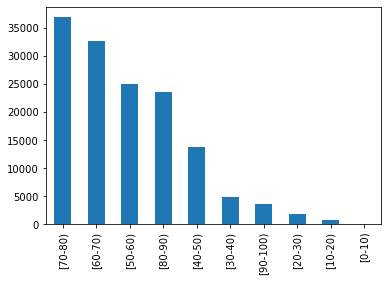

In [10]:
df['age'].value_counts().plot(kind="bar")

In [11]:
sum(df.race == "?")

for i in df.columns: 
    print(i, sum(df[i] == "?"))

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


encounter_id 0
patient_nbr 0
race 3309
gender 0
age 0
weight 139122
admission_type_id 0
discharge_disposition_id 0
admission_source_id 0
time_in_hospital 0
payer_code 54190
medical_specialty 69463
primary_diagnosis_code 33
other_diagnosis_codes 0
number_outpatient 0
number_inpatient 0
number_emergency 0
num_lab_procedures 0
number_diagnoses 0
num_medications 0
num_procedures 0
ndc_code 0
max_glu_serum 0
A1Cresult 0
change 0
readmitted 0


In [12]:
df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
primary_diagnosis_code          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    23462
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
dtype: int64

In [13]:
df.iloc[0:5, 0:10]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [14]:
df.iloc[0:5, 10:17]

,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency
0,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0
1,?,?,276,250.01|255,0,0,0
2,?,?,648,250|V27,2,1,0
3,?,?,8,250.43|403,0,0,0
4,?,?,197,157|250,0,0,0


In [15]:
df.iloc[0:5, 17:]

,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,41,1,1,0,NaN,None,None,No,NO
1,59,9,18,0,68071-1701,None,None,Ch,>30
2,11,6,13,5,0378-1110,None,None,No,NO
3,44,7,16,1,68071-1701,None,None,Ch,NO
4,51,5,8,0,0049-4110,None,None,Ch,NO


In [16]:
df['A1Cresult'].value_counts()

None    117650
>8       13110
Norm      6955
>7        5709
Name: A1Cresult, dtype: int64

In [17]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


**Student Response**: ??

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    
**a. Field(s) with high amount of missing/zero values**

The following contains `?` as missing values
* `weight`:  139,122
* `medical_speciality`: 69,463
* `payer_code`: 54,190
* `race`: 3,309
* `primary_diagnosis_code`: 33

The following variable contains Na as missing values: 
* `ndc_code`: 23,462

The following variables contain `None` as missing values: 
*  `max_glu_serum`:   136,409
* `A1Cresult`:    117,650

In [18]:
df1a = df.copy()
# ? and None are the missing value codes 
df1a = df1a.replace(["?", "None"], np.nan)
df1a.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,NaN,NaN,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,NaN,NaN,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,NaN,NaN,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,NaN,NaN,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,NaN,NaN,Ch,NO


In [19]:
isna_df = pd.DataFrame(df1a.isna().sum(), columns=['Num_of_NAs'])
isna_df['Perc'] = isna_df['Num_of_NAs']/isna_df.shape[0]
isna_df.sort_values(by=['Perc'], ascending=False)

,Num_of_NAs,Perc
weight,139122,5350.846154
max_glu_serum,136409,5246.500000
A1Cresult,117650,4525.000000
medical_specialty,69463,2671.653846
payer_code,54190,2084.230769
ndc_code,23462,902.384615
race,3309,127.269231
primary_diagnosis_code,33,1.269231
encounter_id,0,0.000000
number_emergency,0,0.000000


**Question 2b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?**

In [20]:
numeric_fields = [c for c in df.columns if df[c].dtype == "int64"]
numeric_fields

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures']

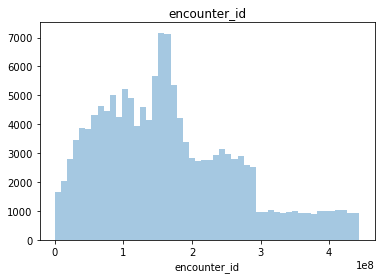

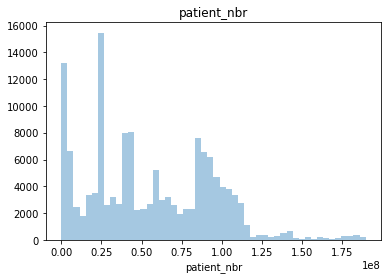

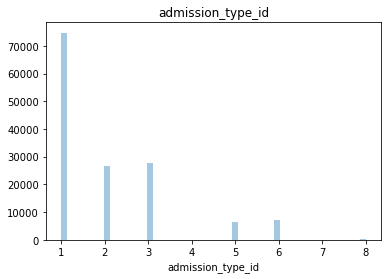

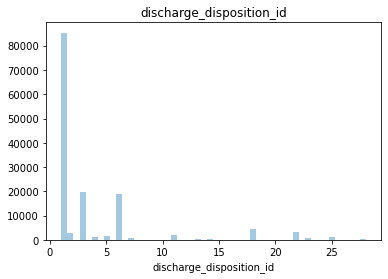

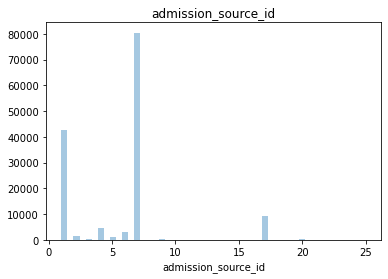

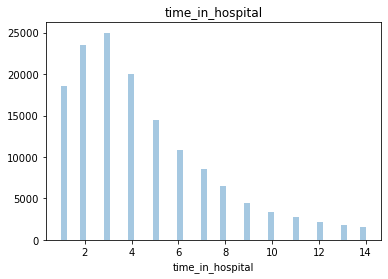

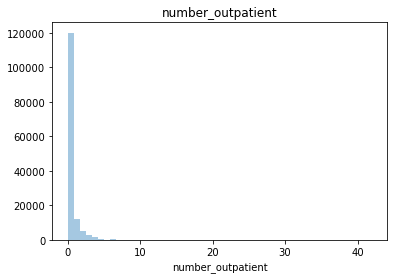

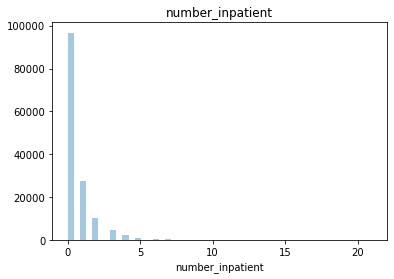

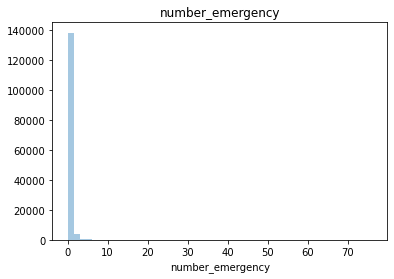

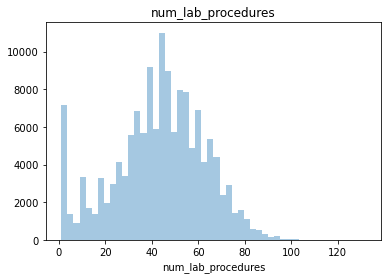

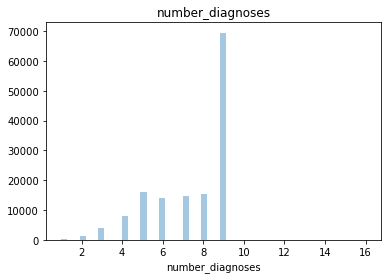

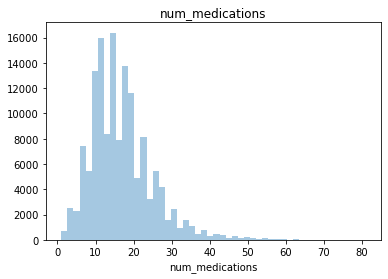

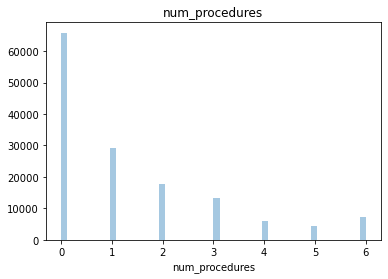

In [21]:
for c in numeric_fields:
    sns.distplot(df[c], kde=False)
    plt.title(c)
    plt.show()

In [22]:
df.weight.value_counts()

?            139122
[75-100)       1817
[50-75)        1133
[100-125)       890
[125-150)       200
[25-50)         118
[0-25)           67
[150-175)        55
[175-200)        18
>200              4
Name: weight, dtype: int64

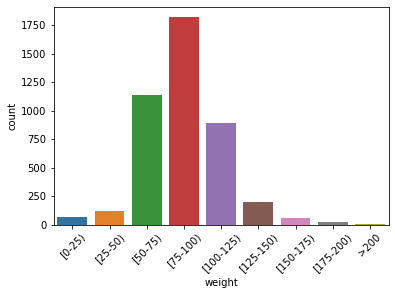

In [23]:
chart = sns.countplot(x = 'weight', data = df, 
                     order=['[0-25)', '[25-50)', '[50-75)',
                            '[75-100)', '[100-125)', '[125-150)',
                            '[150-175)', '[175-200)', '>200'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

**Question 2b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?**

variable `weight` seems (right-skewed a bit) to have the shape of a normal distribution. 


In [24]:
# code based on Udacity class notes 
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [25]:
categorical_feature_list = [ 'gender', 'race', 'admission_type_id', 
                            'discharge_disposition_id', 'admission_source_id', 
                            'payer_code', 'primary_diagnosis_code',
                            'other_diagnosis_codes', 'ndc_code', 'change' ]


In [26]:
val_df = count_unique_values(df, categorical_feature_list) 
val_df

,columns,cardinality
gender,gender,3
race,race,6
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,18
primary_diagnosis_code,primary_diagnosis_code,717
other_diagnosis_codes,other_diagnosis_codes,19374
ndc_code,ndc_code,251
change,change,2


**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)

Based on the above code chunk, variables `other_diagnosis_codes`, `ndc_code` and `primary_diagnosis_code` all have high cardinality. 

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.

In [27]:
df['age'].isna().sum()

0

In [28]:
df.age.value_counts(dropna=False)

[70-80)     36928
[60-70)     32741
[50-60)     25095
[80-90)     23527
[40-50)     13729
[30-40)      4964
[90-100)     3619
[20-30)      1927
[10-20)       733
[0-10)        161
Name: age, dtype: int64

In [29]:
df.age.value_counts()
df.gender.value_counts()

Female             76185
Male               67234
Unknown/Invalid        5
Name: gender, dtype: int64

The dataset contains more females than males but the imbalance in gender is not big-enough to imnpact the quality of models

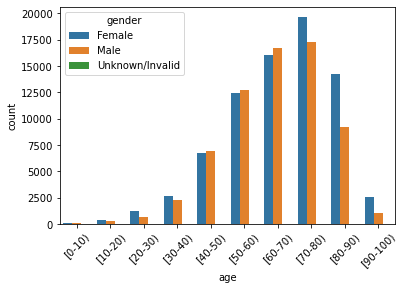

In [30]:
# ax = sns.countplot(x="age", data=df)
ax = sns.countplot(x="age", hue="gender", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Although the age distribution is between 0-100, most of the data lies between 30-90. Any models built using this data wont generalize for ages < 30 and ages > 90.  

In [31]:
df[df.gender == 'Unknown/Invalid']

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
40909,98634858,100695042,Other,Unknown/Invalid,[70-80),?,3,1,1,1,?,Cardiology,414,411|401,0,0,0,5,4,22,5,0591-0460,None,None,Ch,NO
40910,98634858,100695042,Other,Unknown/Invalid,[70-80),?,3,1,1,1,?,Cardiology,414,411|401,0,0,0,5,4,22,5,0093-7272,None,None,Ch,NO
105847,226864668,60524946,?,Unknown/Invalid,[60-70),?,1,1,7,1,CP,?,808,873|E813,0,0,0,38,5,6,1,NaN,None,None,No,NO
116160,257364294,78119847,?,Unknown/Invalid,[70-80),?,1,22,7,8,CP,?,850,805|808,0,0,0,59,9,21,2,0615-7982,None,None,Ch,NO
116161,257364294,78119847,?,Unknown/Invalid,[70-80),?,1,22,7,8,CP,?,850,805|808,0,0,0,59,9,21,2,0173-0861,None,None,Ch,NO


Note some `Unknown/Invalid` entries in `gender` variable. They all are for age range `[70-80)`

In [32]:
######NOTE: The visualization will only display in Chrome browser. ########
# import tensorflow_data_validation as tfdv
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 

# full_data_stats = tfdv.generate_statistics_from_dataframe(df1)
# tfdv.visualize_statistics(full_data_stats)

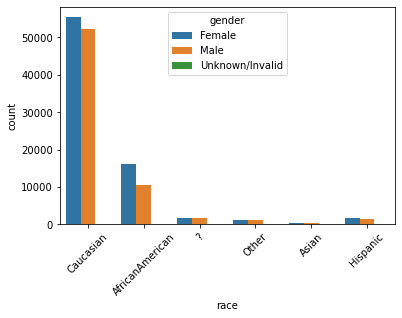

In [33]:
ax = sns.countplot(x = "race", hue="gender", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Note Caucasian is over-represented in the population. To achieve demographic parity, we need to create a dataset that is representative of all races.

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [34]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
print(ndc_code_df.shape)

(269, 7)


In [35]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [36]:
# clean up the column names
# ndc_code_df.columns = [c.lower() for c in ndc_code_df.columns]
# ndc_code_df.columns = [c.replace(' ', '_') for c in ndc_code_df.columns]
# ndc_code_df.columns

In [37]:
# are there any duplicates
ndc_code_df[ndc_code_df.duplicated(keep=False)] #there are two duplicated rows

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
150,0781-5634,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
151,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
263,0781-5634,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug


In [38]:
# remove any duplicates
print('Before removing duplicates in ndc_code_df :', ndc_code_df.shape)
ndc_code_df.drop_duplicates(keep='first', inplace=True)
print('After removing duplicates in ndc_code_df :', ndc_code_df.shape)
print('How many duplicates remaining? :', ndc_code_df.duplicated(keep=False).sum())

Before removing duplicates in ndc_code_df : (269, 7)
After removing duplicates in ndc_code_df : (267, 7)
How many duplicates remaining? : 0


In [39]:
from student_utils import reduce_dimension_ndc

In [40]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [41]:
print('reduce_dim_df.shape :', reduce_dim_df.shape)

print('df.shape :', df.shape)

reduce_dim_df.shape : (119962, 26)
df.shape : (143424, 26)


In [42]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [43]:
print(df['ndc_code'].nunique())
print(reduce_dim_df['generic_drug_name'].nunique())

251
22


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [44]:
# ?select_first_encounter
reduce_dim_df.shape

(119962, 26)

In [45]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [46]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


In [47]:
first_encounter_df['gender'].value_counts()

Female             45236
Male               41672
Unknown/Invalid        4
Name: gender, dtype: int64

## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [48]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, 
                                              grouping_field_list, 
                                              'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [49]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [50]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Glipizide, Insulin Human]",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Human Insulin, Rosiglitazone Maleate]",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,"[Glipizide, Human Insulin]",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,None,None,No,>30,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,None,None,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [51]:
agg_drug_df.weight.value_counts(dropna=False)
# agg_drug_df.payer_code.value_counts(dropna=False)
# agg_drug_df.age.value_counts(dropna=False)

?            54127
[75-100)       840
[50-75)        542
[100-125)      392
[125-150)      104
[25-50)         58
[0-25)          36
[150-175)       23
[175-200)        8
>200             3
Name: weight, dtype: int64

In [52]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide',
       '

Student response: ??

Based on the EDA, let us include the following variables: `gender`, `age`, `admission_type_id`, 
`primary_diagnosis_code`, other_diagnosis_codes, num_lab_procedures, num_medications, change,
readmitted

In [53]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ "admission_type_id", "change", "primary_diagnosis_code", 
                                "other_diagnosis_codes", "readmitted"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['num_lab_procedures', 'num_medications']
PREDICTOR_FIELD = 'time_in_hospital'


In [54]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [55]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride',
       'Glyburide', 'Glyburide_And_Metformin_Hydrochloride',
       'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human',
       'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide',
       'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone',
       'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide',
       '

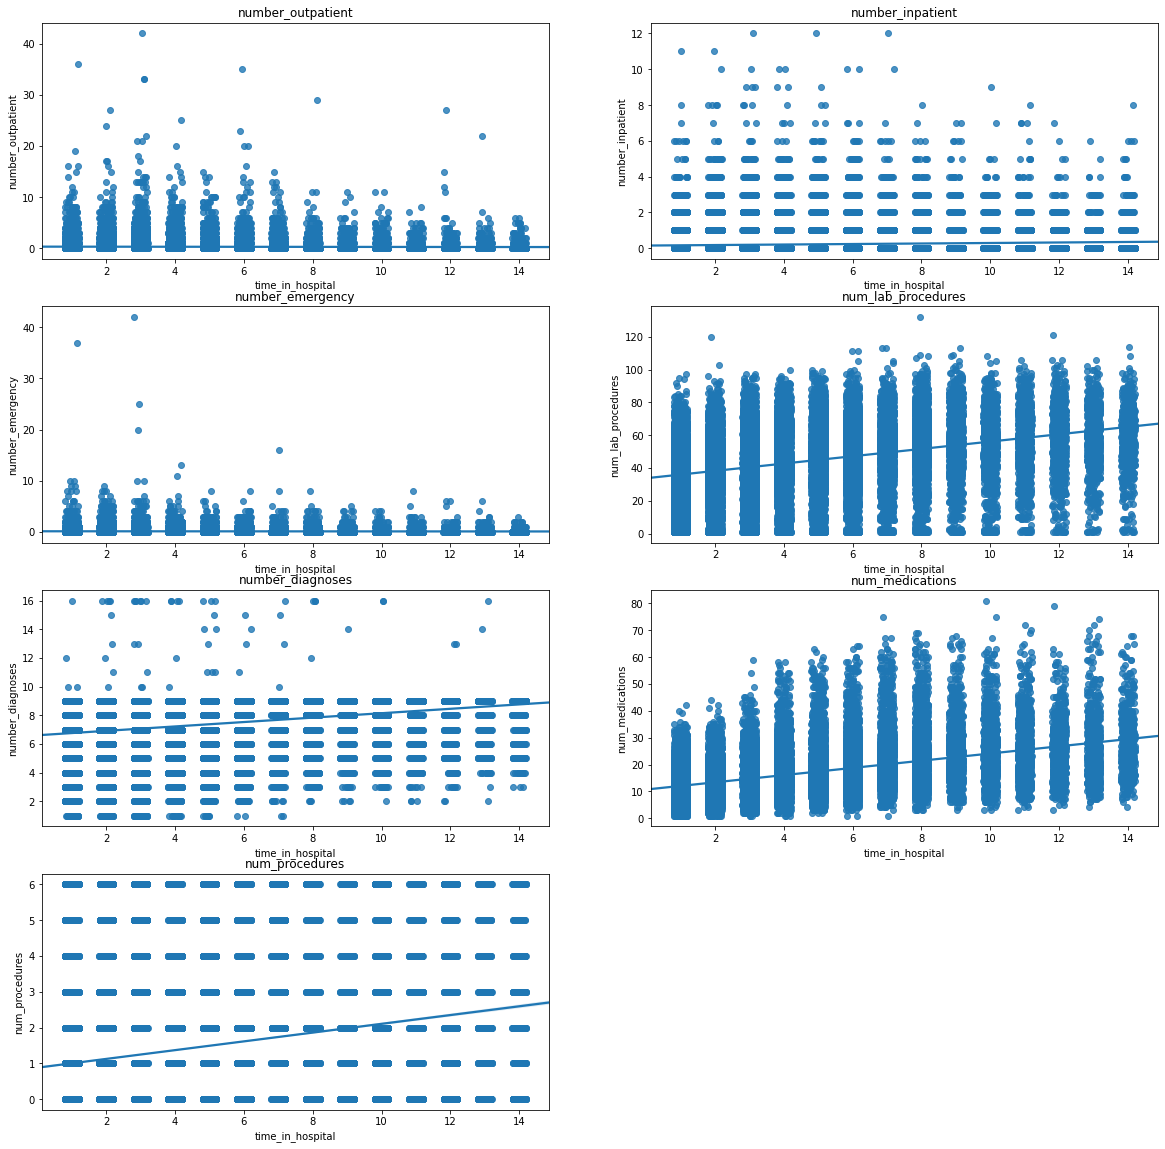

In [56]:
# plot the x-var with the outcome

all_numeric = ['number_outpatient', 'number_inpatient', 'number_emergency', 
               'num_lab_procedures','number_diagnoses', 'num_medications', 
               'num_procedures']

plt.figure(figsize=(20, 20))
columns = 2 
for var in range(len(all_numeric)):
    plt.subplot(len(all_numeric)/columns + 1, columns, var+1).set_title(all_numeric[var])
    sns.regplot(data = agg_drug_df, 
                x = "time_in_hospital", 
                y=all_numeric[var], 
                truncate=False, 
                x_jitter=0.2)
    
    

In [57]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, 
                                             student_numerical_col_list, 
                                             PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [58]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [59]:
processed_df.head()

,patient_nbr,time_in_hospital,admission_type_id,change,primary_diagnosis_code,other_diagnosis_codes,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,48330783,13.0,2,Ch,398,427|38,NO,Caucasian,Female,[80-90),0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,68,28
1,63555939,12.0,3,Ch,434,198|486,NO,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,33,18
2,42519267,1.0,1,Ch,197,157|250,NO,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,51,8
3,89869032,9.0,1,No,250.7,403|996,>30,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,47,17
4,82637451,3.0,2,No,414,411|250,>30,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,31,16


In [60]:
processed_df.shape

(56133, 33)

In [61]:
processed_df['patient_nbr'].nunique()

56133

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [62]:
processed_df.head(3)

,patient_nbr,time_in_hospital,admission_type_id,change,primary_diagnosis_code,other_diagnosis_codes,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,48330783,13.0,2,Ch,398,427|38,NO,Caucasian,Female,[80-90),0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,68,28
1,63555939,12.0,3,Ch,434,198|486,NO,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,33,18
2,42519267,1.0,1,Ch,197,157|250,NO,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,51,8


In [63]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')


In [64]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [65]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      7532
2.0      9473
3.0     10028
4.0      7681
5.0      5566
6.0      4122
7.0      3231
8.0      2419
9.0      1655
10.0     1292
11.0     1054
12.0      807
13.0      702
14.0      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


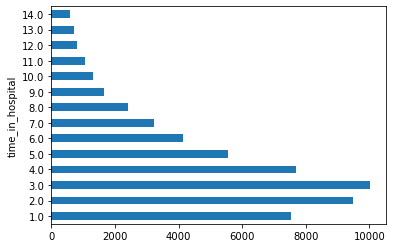

In [66]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4529
2.0     5643
3.0     6047
4.0     4558
5.0     3337
6.0     2474
7.0     1927
8.0     1435
9.0     1013
10.0     783
11.0     653
12.0     507
13.0     411
14.0     363
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


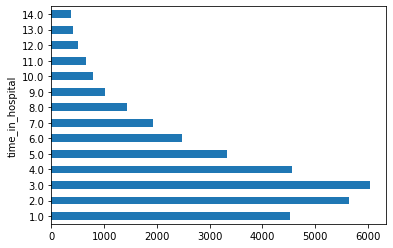

In [67]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1462
2.0     1913
3.0     1993
4.0     1591
5.0     1135
6.0      835
7.0      665
8.0      481
9.0      309
10.0     251
11.0     200
12.0     142
13.0     140
14.0     109
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


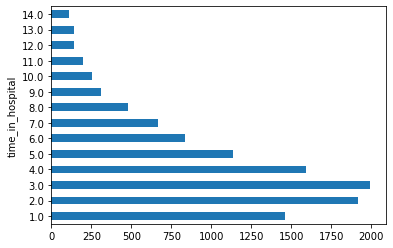

In [68]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


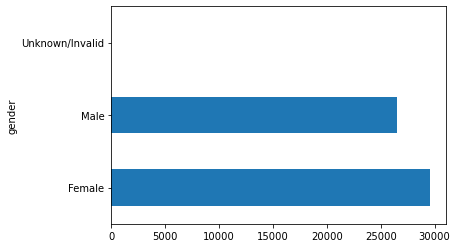

In [69]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17773
Male      15907
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


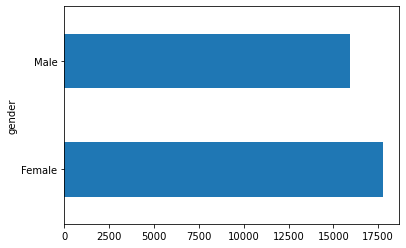

In [70]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5886
Male               5339
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


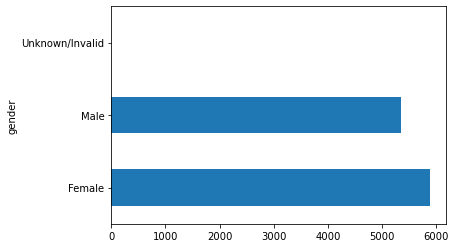

In [71]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [72]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [73]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [74]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [75]:
vocab_file_list

['./diabetes_vocab/admission_type_id_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/other_diagnosis_codes_vocab.txt',
 './diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt'

In [76]:
student_categorical_col_list

['admission_type_id',
 'change',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'readmitted',
 'race',
 'gender',
 'age',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [77]:
!cat ./diabetes_vocab/admission_type_id_vocab.txt

00
5
3
1
2
6
8
4
7


In [78]:
d_train.iloc[0:3, 0:10]

,patient_nbr,time_in_hospital,admission_type_id,change,primary_diagnosis_code,other_diagnosis_codes,readmitted,race,gender,age
0,54736506,2.0,5,Ch,274,428|786,NO,Caucasian,Male,[70-80)
1,38617533,4.0,3,No,427,416|250,>30,Caucasian,Female,[60-70)
2,4406616,5.0,1,Ch,486,427|276,NO,AfricanAmerican,Male,[50-60)


In [79]:
d_train.iloc[0:3, 10:17]

,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0


In [80]:
d_train.iloc[0:3, 17:25]

,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazole_And_Metformin_Hydrochloride
0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0


In [81]:
d_train.iloc[0:3, 25:]

,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications
0,0,0,0,0,0,0,40,10
1,0,0,0,0,0,0,35,6
2,0,0,0,0,0,0,95,25


In [82]:
student_categorical_col_list

['admission_type_id',
 'change',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'readmitted',
 'race',
 'gender',
 'age',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glipizide_And_Metformin_Hydrochloride',
 'Glyburide',
 'Glyburide_And_Metformin_Hydrochloride',
 'Glyburide-metformin_Hydrochloride',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole_And_Metformin_Hydrochloride',
 'Pioglitazone',
 'Pioglitazone_Hydrochloride_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [83]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 607 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 9711 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gend

In [84]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=0, dtype=tf.string, default_value=-1), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f78103f8710>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
tf.Tensor(
[[ 0.02065695 -0.08944906  0.43623236 ... -0.37426555  0.41636005
  -0.1760433 ]
 [ 0.02065695 -0.08944906  0.43623236 ... -0.37426555  0.41636005
  -0.1760433 ]
 [ 0.02065695 -0.08944906  0.43623236 ... -0.37426555  0.41636005
  -0.1760433 ]
 ...
 [ 0.02065695 -0.08944906  0.43623236 ... -0.37426555  0.41636005
  -0.1760433 ]
 [-0.51313514  0.12568441  0.29708424 ... -0.1062884  -0.37878427
   0.03685779]
 [-0.51313514  0.12568441  0.29708424 ... -0.1062884  -0.37878427
   0.03685779]], shape=(128, 10), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [85]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [86]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

#### What are the numerical columns in our dataset? 

In [87]:
student_numerical_col_list

['num_lab_procedures', 'num_medications']

In [88]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [89]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f781b503f80>, mean=43.60905581947743, std=20.12339044242782))

tf.Tensor(
[[ 0.2 ]
 [ 1.1 ]
 [-1.1 ]
 [-0.9 ]
 [ 0.55]
 [ 0.35]
 [ 1.3 ]
 [-0.6 ]
 [-0.55]
 [ 0.75]
 [-0.45]
 [ 0.6 ]
 [-0.05]
 [ 1.6 ]
 [ 0.05]
 [ 0.5 ]
 [ 1.75]
 [-0.4 ]
 [-2.  ]
 [-0.2 ]
 [-0.05]
 [ 1.  ]
 [ 1.  ]
 [-1.2 ]
 [ 0.9 ]
 [ 0.35]
 [ 0.95]
 [-0.65]
 [ 0.5 ]
 [ 0.6 ]
 [ 1.35]
 [ 0.55]
 [ 0.9 ]
 [-1.2 ]
 [ 0.25]
 [-0.1 ]
 [ 1.8 ]
 [ 0.6 ]
 [ 0.6 ]
 [-0.45]
 [ 0.85]
 [ 1.65]
 [ 1.05]
 [ 0.  ]
 [ 0.6 ]
 [ 0.1 ]
 [ 0.3 ]
 [ 0.65]
 [ 0.3 ]
 [ 1.2 ]
 [-0.1 ]
 [ 0.5 ]
 [ 0.15]
 [ 1.1 ]
 [ 0.2 ]
 [-2.05]
 [ 0.75]
 [ 0.05]
 [ 0.75]
 [ 0.3 ]
 [-0.05]
 [-1.25]
 [ 1.4 ]
 [-0.8 ]
 [-0.6 ]
 [-2.1 ]
 [ 1.1 ]
 [-0.4 ]
 [-2.1 ]
 [ 2.  ]
 [ 0.2 ]
 [ 0.5 ]
 [-0.65]
 [-1.85]
 [-0.25]
 [-0.45]
 [-0.4 ]
 [-0.9 ]
 [-0.15]
 [ 0.  ]
 [ 0.  ]
 [ 

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [90]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [91]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=20, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [92]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 264 steps, validate for 88 steps
Epoch 1/10
264/264 [==============================] - 29s 108ms/step - loss: 28.6826 - mse: 28.5856 - val_loss: 24.3745 - val_mse: 24.0631
Epoch 2/10
264/264 [==============================] - 18s 66ms/step - loss: 22.1935 - mse: 21.8107 - val_loss: 17.4150 - val_mse: 16.8321
Epoch 3/10
264/264 [==============================] - 17s 65ms/step - loss: 16.8158 - mse: 16.1124 - val_loss: 13.6168 - val_mse: 12.5568
Epoch 4/10
264/264 [==============================] - 17s 66ms/step - loss: 14.1050 - mse: 13.2406 - val_loss: 12.7572 - val_mse: 11.9865
Epoch 5/10
264/264 [==============================] - 17s 66ms/step - loss: 12.5362 - mse: 11.6585 - val_loss: 11.4412 - val_mse: 10.2172
Epoch 6/10
264/264 [==============================] - 17s 66ms/step - loss: 11.9912 - mse: 10.9843 - val_loss: 11.4263 - val_mse: 10.6335
Epoch 7/10
264/264 [==============================] - 17s 66ms/step - loss: 10.7351 - mse: 9.8996 - val_loss: 10.2135 - val_mse:

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [93]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [94]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [95]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [96]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,2.499243,1.0,3.487263,0.695418
1,6.253035,3.0,4.615691,0.696261
2,3.146257,3.0,7.105718,0.697790
3,3.154335,1.0,2.311251,0.693771
4,1.033303,3.0,5.883952,0.696963


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [97]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [98]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [99]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,97838352,Female,Caucasian,1.0,0,0
1,97817931,Female,AfricanAmerican,3.0,0,0
2,80534763,Male,Caucasian,3.0,1,0
3,43463331,Female,AfricanAmerican,1.0,0,0
4,42461442,Female,Caucasian,3.0,1,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [100]:
# AUC, F1, precision and recall
# Summary

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

accuracy_score(y_true, y_pred)



0.7033671833244255

In [101]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.63      0.72      6959
           1       0.58      0.83      0.68      4267

    accuracy                           0.70     11226
   macro avg       0.72      0.73      0.70     11226
weighted avg       0.75      0.70      0.71     11226



**Question 11a) Explain the precision-recall tradeoff in regard to how you have optimized your model.**

Note Precision and Recall are performance metrics commonly used in data science projects. It is easier to explain the meaning using a simple example. The following example is based on wikipedia (en.wikipedia.org/wiki/Precision_and_recall). Imagine you have written a software program that identifies dogs from the digital images. In our case, dogs are the relevant element. You test the code using some images (cats: 10, and dogs: 12), and it identifies 8 images as dogs. Of the eight images, only 5 are dogs (True positives). The remaining three are cats (False Positives). Seven dogs were missed (False Negatives) and 7 cats were correctly ignored (True negatives). How to evaluate the program performance using Precision and Recall? 

**Precision (a.k.a positive predictive value):**
$$ Precision = \frac{TP}{TP + FP} = \frac{\text{Number of true positives}} {\text{Number of positive calls}} $$ where TP: Number of true positives and FP: Number of False positives

$$ Precision = \frac{5}{8} $$

**Recall (a.k.a sensitivity or true positive rate):**
$$ Recall = \frac{TP}{TP + FN} $$ where FN = False negatives

$$ Recall = \frac{5}{12}$$ 

Sensitivity refers to the test's ability to correctly identify the cases.

Note that there is no one measure that can be used to judge model performance. One commonly uses both precision and recall or use weighted score method like F1-score for evaluation. The other popular model evaluation technique is called Area Under the Curve (AUC) or ROC curves. You can read about the two methods here: 
* Receiver Operating Characteristics (ROC): https://en.wikipedia.org/wiki/Receiver_operating_characteristic 
* F1-score: https://en.wikipedia.org/wiki/F-score

**Question 11b: What are some areas of improvement for future iterations?**

*Precision-Recall tradeoff*

* Removing some of the rows with missing values
* By changing the thresold, we can impact the precision and recall. The better way is use F1-score which combines (harmonic mean) Precision and Recall scores. F1-score is a good measure when the data is imbalanced in the outcome. Our preliminary model based on F1-score seems to be performing better. Here is how can improve the model: 

* experimenting with the learning rate
* increasing epochs 
* try different optimizers 
* consider neural network for training 


Here is how we can compute ROC curve:

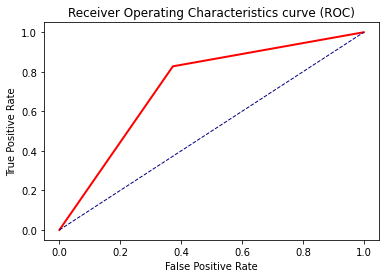

In [102]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
plt.plot(fpr, tpr, color='red', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics curve (ROC)')    
plt.show()

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [103]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [6125]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


In [104]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,6125,race,?,179,148,79,15,133,100,115,212,327,11226
1,1,binary 0/1,6125,race,AfricanAmerican,1069,938,455,136,802,614,750,1257,2007,11226
2,1,binary 0/1,6125,race,Asian,25,31,13,1,30,12,13,43,56,11226
3,1,binary 0/1,6125,race,Caucasian,4651,3745,1964,557,3188,2687,3244,5152,8396,11226
4,1,binary 0/1,6125,race,Hispanic,113,133,48,20,113,65,85,161,246,11226
5,1,binary 0/1,6125,race,Other,88,106,35,7,99,53,60,134,194,11226
6,1,binary 0/1,6125,gender,Female,3409,2477,1508,345,2132,1901,2246,3640,5886,11226
7,1,binary 0/1,6125,gender,Male,2715,2624,1086,391,2233,1629,2020,3319,5339,11226
8,1,binary 0/1,6125,gender,Unknown/Invalid,1,0,0,0,0,1,1,0,1,11226


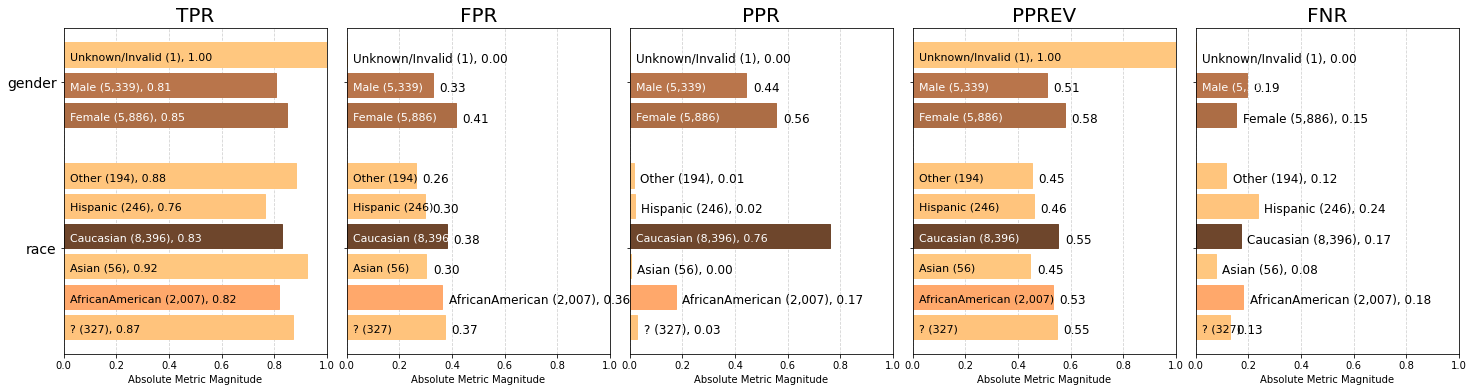

In [105]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [106]:
# test reference group with Caucasian Male
# bdf = b.get_disparity_predefined_groups(clean_xtab, 
#                     original_df=ae_df, 
#                     ref_groups_dict={'race':'Caucasian', 'gender':'Male'
#                                      }, 
#                     alpha=0.05, 
#                     check_significance=False)

bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Asian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

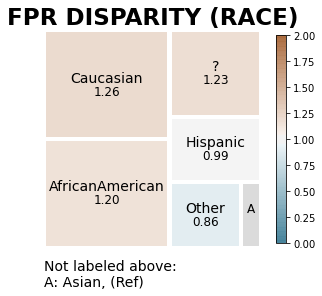

In [107]:
# Plot two metrics

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity',
                                  attribute_name='race')

# Is there significant bias in your model for either race or gender?

**Question 12**

Based on our FPR disparity Caucasians, Hispanics, and African americans are more likely to be falsely identified than the reference group (Asians) by 3.26, 3.19 and 2.93 times. Note Asians form the reference group (which is set to one).

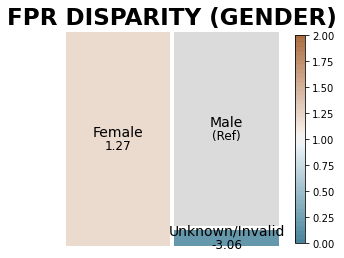

In [108]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

**Question 12** FPR disparity magnitute across is low. FPR disparity magnitudes for females (1.14) and male (1.0) respectively. 

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

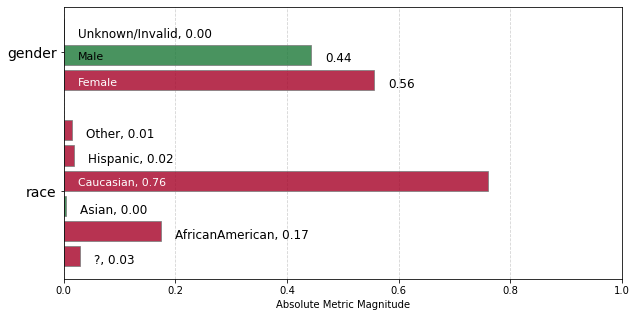

In [109]:
# Reference group fairness plot

x = aqp.plot_fairness_group(fdf, group_metric='ppr')

The above chart plots the positive predictive rate disparity (PPR) for gender and race. Colors indicate fairness attribute (green: 'True', red: 'False').

Plots (see above) can be used to determine whether gender groups and race fall within the "fair" range. As we can see, gender is within the fair range but the race is not. 